In [1029]:
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import explained_variance_score, r2_score, mean_absolute_error
from sklearn.tree import export_graphviz
import pandas as pd
import numpy as np
import requests 
import config # gitignored config.py file with API keys
import json 
import pydot
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('ggplot')
sns.set(rc={'figure.figsize':(20,8.27)})
%matplotlib inline

# Define the urban area: ZIP, Price, Rent, Lat, and Lng 
### Pulling all zip codes for the urban area

In [1036]:
# Retrieved on 05/28/2020 from https://worldpostalcode.com/united-states/new-york/new-york-city 
df_zipcodes = pd.read_csv('nyc_boroughs.csv', index_col = 0)
df_zipcodes.tail(2)

,zip,borough
238,11694,Queens
239,11697,Queens


In [1037]:
df_zipcodes.shape

(240, 2)

This looks like a good size (n=240) sample of zip codes that can be used for the analysis

In [1038]:
df_zipcodes.rename(columns={'borough':'Borough', 'zip':'Zipcode'}, inplace=True)
df_zipcodes.groupby('Borough').count()

,Zipcode
Borough,
Bronx,25
Brooklyn,43
Manhattan,96
Queens,63
Staten,13


### Adding Zillow price estimates 
Use the list of sample zip codes to get good price estimates, in my case, latest estimates of 2-bedroom condo units

In [1039]:
# Retrieved on 05-18-2020 from https://www.zillow.com/research/data/
df_prices = pd.read_csv('condo_prices.csv', index_col=0)

In [1040]:
# This data set contains zillow estimates for the entire nation
df_prices.shape

(10939, 299)

In [1041]:
# Inspect the columns 
df_prices.head(2)

,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,1996-02-29,...,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31
RegionID,,,,,,,,,,,,,,,,,,,,,
61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,215591.0,214255.0,...,1249908.0,1239499.0,1219219.0,1203053.0,1188642.0,1182534.0,1175894.0,1153407.0,1123011.0,1085220.0
84654,1,60657,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,194597.0,194456.0,...,403689.0,403756.0,403181.0,402122.0,401073.0,400025.0,399451.0,399424.0,400541.0,402007.0


In [1042]:
# Only need the relevant price, say 2019-11-30, and RegionName (zipcode), plus Metro for checks
df_prices.drop(df_prices.columns.difference(['RegionName', '2019-11-30']), 1, inplace=True)

In [1043]:
df_nyc_prices = df_zipcodes.merge(df_prices, left_on='Zipcode', right_on='RegionName')
df_nyc_prices.shape

(157, 4)

Merged data set has less rows than original zip codes list but thats fine as there might have been some P.O boxes or reserved codes. The new list now has meaningful first feature - price estimate.

Check if all observations map to New York city boroughs or if there any unexpected values. Looks fine so far!

In [1044]:
df_nyc_prices.groupby('Borough').count()

,Zipcode,RegionName,2019-11-30
Borough,,,
Bronx,16,16,16
Brooklyn,38,38,38
Manhattan,41,41,41
Queens,51,51,51
Staten,11,11,11


Finally, drop control column 'RegionName', rename the column to 'Price' and check if there are any missing values.

In [1045]:
df_nyc_prices.rename(columns={'2019-11-30':'Price'}, inplace=True)
df_nyc_prices.drop(['RegionName'], axis=1, inplace=True)
df_nyc_prices['Price'].isna().values.any()

False

### Addining Zillow rental estimates

In [1046]:
# Retrieved on 05-18-2020 from https://www.zillow.com/research/data/
df_rents=pd.read_csv('condo_rentals.csv', index_col = 0)

In [1047]:
df_rents.shape

(13181, 119)

In [1048]:
df_rents.head(2)

,RegionName,City,State,Metro,CountyName,SizeRank,2010-09,2010-10,2010-11,2010-12,...,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01
RegionID,,,,,,,,,,,,,,,,,,,,,
61639,10025,New York,NY,New York-Newark-Jersey City,New York County,1,3031.0,3058.0,3031.0,3015.0,...,3785.0,3788.0,3786.0,3784.0,3766.0,3779.0,3843.0,3873.0,3835.0,NaN
84654,60657,Chicago,IL,Chicago-Naperville-Elgin,Cook County,2,1790.0,1787.0,1784.0,1774.0,...,2039.0,2070.0,2105.0,2140.0,2168.0,2185.0,2125.0,NaN,2053.0,1996.0


In [1049]:
# Only need relevant price, say 2019-11-30, and RegionName (zipcode), plus Metro for checks
df_rents.drop(df_rents.columns.difference(['RegionName', '2019-11']), 1, inplace=True)

In [1050]:
df_nyc_prices_rents = df_nyc_prices.merge(df_rents, left_on='Zipcode', right_on='RegionName')
df_nyc_prices_rents.shape

(136, 5)

More observations (rows) were lost because not all zip codes had a rental estimate. Still seems to be a reasonable sample size (n=136).

In [1051]:
df_nyc_prices_rents.groupby('Borough').count()

,Zipcode,Price,RegionName,2019-11
Borough,,,,
Bronx,16,16,16,15
Brooklyn,34,34,34,29
Manhattan,26,26,26,25
Queens,49,49,49,49
Staten,11,11,11,11


Moreover, from the grouped table above, it seems that some zip codes do have a price estimate but do not have rent estimate. So, drop missing values and check the data set. Drop control column and rename column 'Rent'.

In [1052]:
df_nyc_prices_rents.rename(columns={'2019-11':'Rent'}, inplace=True)
df_nyc_prices_rents.drop(['RegionName'], axis=1, inplace=True)
df_nyc_prices_rents['Rent'].isna().values.any()

True

In [1053]:
df_nyc_prices_rents.shape

(136, 4)

In [1054]:
df_nyc_prices_rents.dropna(inplace=True)
df_nyc_prices_rents.shape

(129, 4)

In [1055]:
df_nyc_prices_rents.shape

(129, 4)

In [1056]:
df_nyc_prices_rents['Rent'].isna().values.any()

False

Final size is smaller (n=129) but there are no missing values

## Exploratory visual analysis

Big picture - scatter of rents and prices in the city with respective histograms

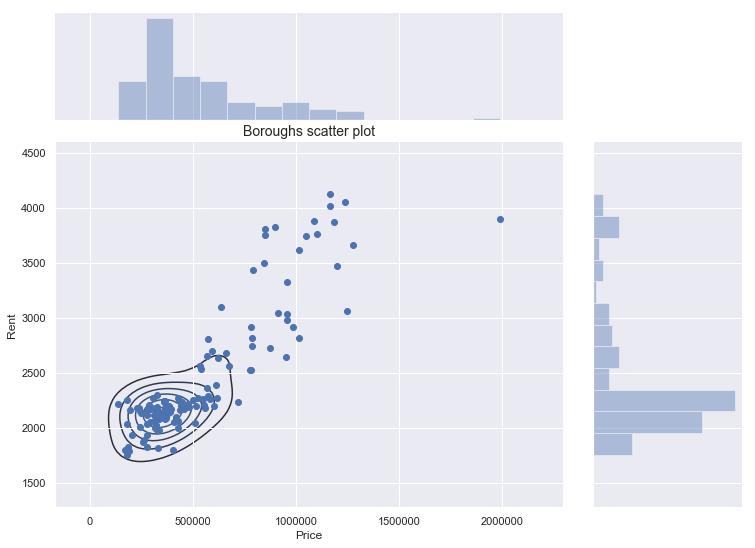

In [1057]:
sns.jointplot("Price", "Rent", data=df_nyc_prices_rents,
                  height=5, ratio=3, color="b").plot_joint(sns.kdeplot, zorder=0, n_levels=6)

plt.gcf().set_size_inches(11.7, 8.27)
plt.title("Boroughs scatter plot", fontsize=14)
plt.show()

When plotting 'Rent' against 'Price" it seems that the data are not homegeneous at all. 

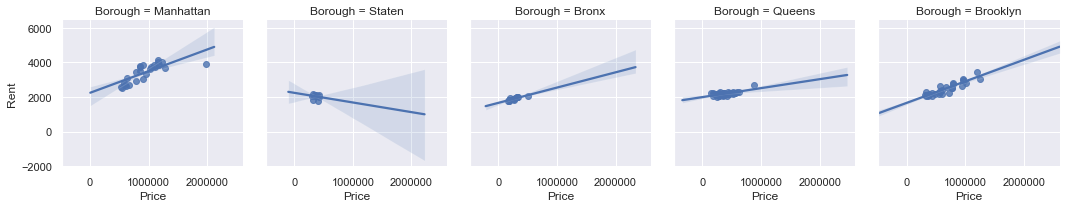

In [1058]:
g1 = sns.lmplot(x='Price', y='Rent', data=df_nyc_prices_rents, ci=85,
                col='Borough', height=3, robust=False)
g1 = g1.set_axis_labels('Price', 'Rent')
plt.show()

Splitting by boroughs confirms this idea. When looking at the slope of regression lines, rent/price relationship appears to be different. There may be at list 2 or 3 distinct groups.

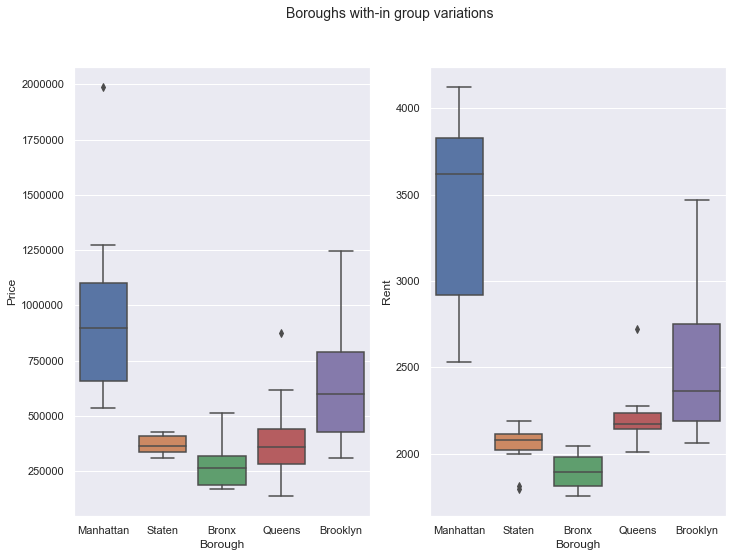

In [1059]:
# Use box plots to assess the variance
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.suptitle("Boroughs with-in group variations", fontsize=14) 
sns.boxplot(x="Borough", y="Price", data = df_nyc_prices_rents, ax=axes[0])
sns.boxplot(x="Borough", y="Rent", data = df_nyc_prices_rents, ax=axes[1])
plt.gcf().set_size_inches(11.7, 8.27)
plt.show()

Variance within the boroughs is large, especially in Manhattan and Brooklyn. This may be a problem for the predictions.

## Adding geospatial data

In [996]:
# Source: https://gist.github.com/erichurst/7882666#file-us-zip-codes-from-2013-government-data
# Retrieved on 05/28/200
#df_zip_coordinates = pd.read_csv('https://gist.githubusercontent.com/erichurst/7882666/raw/5bdc46db47d9515269ab12ed6fb2850377fd869e/US%2520Zip%2520Codes%2520from%25202013%2520Government%2520Data')
# Due to importance of these coordinates, I make a local csv copy
#df_zip_coordinates.to_csv('zip_coordinates.csv')

In [1060]:
df_zip_coordinates= pd.read_csv('zip_coordinates.csv', index_col = 0)
df_zip_coordinates.head()

,ZIP,LAT,LNG
0,601,18.180555,-66.749961
1,602,18.361945,-67.175597
2,603,18.455183,-67.119887
3,606,18.158345,-66.932911
4,610,18.295366,-67.125135


In [1061]:
# Merge nyc dataset with nyc coordinates
df_nyc_prices_rents = df_nyc_prices_rents.merge(df_zip_coordinates, left_on='Zipcode', right_on='ZIP')

In [1062]:
df_nyc_prices_rents.groupby('Borough').count()

,Zipcode,Price,Rent,ZIP,LAT,LNG
Borough,,,,,,
Bronx,15,15,15,15,15,15
Brooklyn,28,28,28,28,28,28
Manhattan,25,25,25,25,25,25
Queens,49,49,49,49,49,49
Staten,11,11,11,11,11,11


In [1063]:
# Now it is okay to drop repetitive Zip column
df_nyc_prices_rents.drop(['ZIP'], axis=1, inplace=True)
df_nyc_prices_rents.shape

(128, 6)

In [1064]:
# Check if there any missing values
df_nyc_prices_rents['LAT'].isna().values.any()

False

In [1065]:
df_nyc_prices_rents['LNG'].isna().values.any()

False

In [1005]:
# Creat a local copy of teh entire data set for audit purposes:
#df_nyc_prices_rents.to_csv('nyc_pyces_rents.csv')

# Adding Local Venues

### Connecting to Foursquares server and data pull

In [72]:
#config.py file stores Client_ID and Client_Secret and is in gitignore
CLIENT_ID = config.CLIENT_ID 
CLIENT_SECRET = config.CLIENT_SECRET 
VERSION = '20191130'

In [458]:
latitude = df_nyc_prices_rents.loc[0, 'LAT'] 
longitude = df_nyc_prices_rents.loc[0, 'LNG'] # neighborhood longitude value
zipcode = df_nyc_prices_rents.loc[0, 'ZIP'] # neighborhood name

LIMIT = 500 
radius = 500

In [459]:
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)


In [460]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ed62c1d660a9f001b4f64fd'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'},
    {'name': '$-$$$$', 'key': 'price'}]},
  'headerLocation': 'Chelsea',
  'headerFullLocation': 'Chelsea, New York',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 61,
  'suggestedBounds': {'ne': {'lat': 40.7551330045, 'lng': -73.99124794397473},
   'sw': {'lat': 40.7461329955, 'lng': -74.00310605602532}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '59ca57dd3d47910ad148e668',
       'name': 'Bluestone Lane',
       'location': {'address': '435 W 31st St',
        'crossStreet': 'btwn 9th & Dyer Ave',
        'lat': 40.7520681,
        'lng': -73.9988477,
        'labeled

In [461]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [1066]:
venues = results['response']['groups'][0]['items']
    
df_nearby_venues = json_normalize(venues) 
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
df_nearby_venues = df_nearby_venues.loc[:, filtered_columns]
df_nearby_venues['venue.categories'] = df_nearby_venues.apply(get_category_type, axis=1)
df_nearby_venues.columns = [col.split(".")[-1] for col in df_nearby_venues.columns]

In [1067]:
print('{} venues were returned by Foursquare.'.format(df_nearby_venues.shape[1]))

4 venues were returned by Foursquare.


In [464]:
def getNearbyVenues(zipcodes, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for zipcode, lat, lng in zip(zipcodes, latitudes, longitudes):
        print('Retrieving local values for the zip code:', zipcode)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            zipcode, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Zip', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [466]:
# Used to update df_nyc_venues table with data from Foursquares server

#df_nyc_venues = getNearbyVenues(zipcodes=df_nyc_prices_rents['Zipcode'],
#                             latitudes=df_nyc_prices_rents['LAT'],
#                             longitudes=df_nyc_prices_rents['LNG']
#                            )


In [1069]:
print(df_nyc_venues.shape)
#Take back up of the data set for audit 
#df_nyc_venues.to_csv('nyc_venues_r500.csv')
df_nyc_venues.head(2)

(5142, 7)


,Zip,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,10001,40.750633,-73.997177,Bluestone Lane,40.752068,-73.998848,Coffee Shop
1,10001,40.750633,-73.997177,You Should Be Dancing…..! / Club 412,40.750306,-73.994743,Dance Studio


In [1070]:
print('There are {} uniques categories.'.format(len(df_nyc_venues['Venue Category'].unique())))

There are 376 uniques categories.


In [1071]:
# One hot encoding
df_nyc_onehot = pd.get_dummies(df_nyc_venues[['Venue Category']], prefix="", prefix_sep="")

# Add neighborhood column back to dataframe
df_nyc_onehot['Zip'] = df_nyc_venues['Zip'] 

# Move neighborhood column to the first column
fixed_columns = [df_nyc_onehot.columns[-1]] + list(df_nyc_onehot.columns[:-1])
df_nyc_onehot = df_nyc_onehot[fixed_columns]

df_nyc_onehot.head()

,Zip,Accessories Store,Acupuncturist,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Tram,American Restaurant,Antique Shop,Arcade,...,Video Store,Vietnamese Restaurant,Warehouse Store,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,10001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1072]:
df_nyc_onehot.shape

(5142, 377)

In [1081]:
df_nyc_grouped = df_nyc_onehot.groupby('Zip').mean().reset_index()
df_nyc_grouped.head()

,Zip,Accessories Store,Acupuncturist,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Tram,American Restaurant,Antique Shop,Arcade,...,Video Store,Vietnamese Restaurant,Warehouse Store,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,10001,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00
1,10002,0.0,0.0,0.0,0.0,0.0,0.0,0.03,0.0,0.0,...,0.0,0.02,0.0,0.0,0.0,0.01,0.00,0.0,0.01,0.00
2,10004,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00
3,10005,0.0,0.0,0.0,0.0,0.0,0.0,0.06,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.00,0.01,0.0,0.00,0.01
4,10006,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.00,0.03,0.0,0.01,0.00


In [1082]:
df_nyc_grouped.shape

(128, 377)

# Creating analysis data set 

In [1083]:
df_analysis_dataset = df_nyc_prices_rents.merge(df_nyc_grouped, left_on='Zipcode', right_on='Zip')
df_analysis_dataset.drop(['Zipcode', 'Borough', 'LAT', 'LNG', 'Zip'], axis=1, inplace=True)
df_analysis_dataset.head(2)

,Price,Rent,Accessories Store,Acupuncturist,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Tram,American Restaurant,Antique Shop,...,Video Store,Vietnamese Restaurant,Warehouse Store,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,1274766.0,3667.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0
1,1103197.0,3759.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03,0.0,...,0.0,0.02,0.0,0.0,0.0,0.01,0.0,0.0,0.01,0.0


In [1084]:
# Assign target columns
y_price = df_analysis_dataset['Price']
y_rent = df_analysis_dataset['Rent']

# And remove target from the data set
df_analysis_dataset.drop(['Price', 'Rent'], axis=1, inplace=True)

In [1085]:
# Assign features (predictors)
X = df_analysis_dataset

# Saving feature names for later use
feature_list = list(X.columns)

# Check shapes of target and predictors
print("Target y for price:", y_price.shape, " and for rent ", y_rent.shape, " --   Features X ", X.shape)

Target y for price: (128,)  and for rent  (128,)  --   Features X  (128, 376)


# Random forest of regression trees

In [1086]:
def run_random_forests(title, X_features, y_target, size, depth, n_runs, seed):
    
    # Split the data into training and testing using sie parameter
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = size, random_state = seed)
    
    # Create and fit regression object 
    rf_regression = RandomForestRegressor(max_depth=depth, n_estimators=n_runs, random_state=seed)
    rf_regression.fit(X_train, y_train)
    
    # Use regression to make prediction y_hat for checking againg testing data from the split
    y_hat = rf_regression.predict(X_test)
    print("Performance measures for", title, "model")
    print("R2 score: ", round(r2_score(y_test, y_hat), 2))
    print("Explained variance: ", round(explained_variance_score(y_test, y_hat), 2))
    print("Mean absolute error:" , round((np.mean(np.abs((y_test - y_hat) / y_test))), 2))
    print("On average predictions are off by" , round(mean_absolute_error(y_test, y_hat), 0), "$") 
    
    # Call functions to plot features and update tree png file
    plot_feature_importance(title, rf_regression)
    #update_tree_png(title, rf_regression)
    
def plot_features_importance(title, rf_regression):
    
    # Get numerical feature importances
    importances = list(rf_regression.feature_importances_)
    
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) 
                       for feature, importance in zip(feature_list, importances)]
   
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    x_val = [x[0] for x in feature_importances[0:10]]
    y_val = [x[1] for x in feature_importances[0:10]]
    plt.barh(x_val, y_val, edgecolor='black')
    plt.title('Top 10 features for explaining {}:'.format(title))
    plt.show()
    
def update_tree_png(title, rf_regression):
    
    # Pull out one tree from the forest
    tree = rf_regression.estimators_[5]
    
    # Export the image to a dot file
    export_graphviz(tree, out_file = title + '_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
    
    # Use dot file to create a graph
    (graph, ) = pydot.graph_from_dot_file(title + '_tree.dot')
    
    # Write graph to a png file
    graph.write_png(title + '_tree.png')

### Testing performance of price model

Performance measures for price model
R2 score:  0.73
Explained variance:  0.73
Mean absolute error: 0.21
On average predictions are off by 106823.0 $


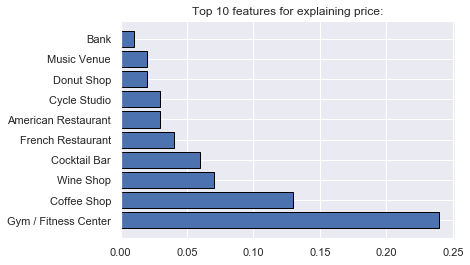

In [1087]:
run_random_forests("price", X, y_price, 0.2, 3, 10000, 0)

### Testing performance rent model

Performance measures for rent model
R2 score:  0.6
Explained variance:  0.61
Mean absolute error: 0.1
On average predictions are off by 260.0 $


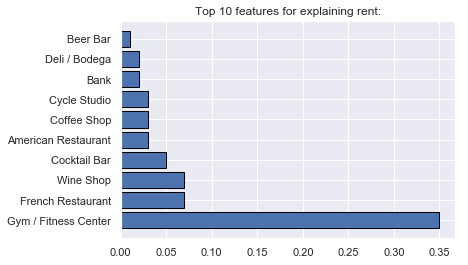

In [1088]:
run_random_forests("rent", X, y_rent, 0.2, 3, 10000, 0)